# Week 2: Blackbody Lab | Christian H. Nunez

In [35]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats

In [36]:
# Define constants:
N = 1.38*10**(-23)
h = 6.626*10**(-34)
lambda_filter = 546.1 * 10**(-9) # m
v = 299792458 / lambda_filter # Hz
kb = 1.38064852 * 10**(-23) # m^2 * kg * s^-2 K^-1
sigma = 5.67 * 10**(-8) # W * * m * K^-4
eps = .45 # emissivity constant

In [51]:
# Multiple measurements of the magnified length and magnified diameter
c = {'Mag_length_m' : [.024, 0.044, .075], # 2.4cm
     'Mag_length_err' : [0.001, 0.001, 0.001], # .1 cm
     'Mag_diam_m' : [0.007, 0.013, 0.021], # .7 cm
     'Mag_diam_err' : [0.0005, .0005, 0.0005], # .05 cm
     'd0_m' : [.062, .061, 0.059],
     'd0_err' : [0.002, 0.002, 0.002],
     'd1_m' : [.432, .736, 1.203],
     'd1_err' : [0.001, 0.001, 0.001],}
cf = pd.DataFrame(c)
cf

,Mag_diam_err,Mag_diam_m,Mag_length_err,Mag_length_m,d0_err,d0_m,d1_err,d1_m
0,0.0005,0.007,0.001,0.024,0.002,0.062,0.001,0.432
1,0.0005,0.013,0.001,0.044,0.002,0.061,0.001,0.736
2,0.0005,0.021,0.001,0.075,0.002,0.059,0.001,1.203


In [52]:
# Surface area model: Lateral surface area of cylinder, outside only (because of reabsorption)
# Remember, pass in MAGNIFIED w, diam. Returns array of surface areas.
def getSurfaceArea(w, diam, d0, d1):
    M = d1/d0
    w = w/M
    diam = diam/M
    return np.pi * w * diam

#Set the surface area:
surfaceAreaArray = getSurfaceArea(cf.Mag_length_m, cf.Mag_diam_m, cf.d0_m, cf.d1_m)
sumOfSurfaceAreas = np.sum(surfaceAreaArray)

cf["Area_m^2"] = surfaceAreaArray

# Define the error in A
def sigmaA(w, sigma_w, diam, sigma_diam, d0, sigma_d0, d1, sigma_d1):
    term1 = ((np.pi * d0 * diam * sigma_w) / d1)**2
    term2 = ((np.pi * w * diam * sigma_d0) / d1)**2
    term3 = ((np.pi * w * d0 * sigma_diam) / d1)**2
    term4 = ((np.pi * d0 * w * diam * sigma_d1)/(d1**2))**2
    return np.sqrt(term1 + term2 + term3 + term4)

cf["SigmaA"] = sigmaA(cf.Mag_length_m, cf.Mag_length_err, cf.Mag_diam_m, cf.Mag_diam_err, cf.d0_m, 
                      cf.d0_err, cf.d1_m, cf.d1_err)

def stdErrorFromArray(array):
    return np.sqrt(np.sum(array**2))/len(array)

def getWeightedMean(valueArray, sigmaArray):
    weights = 1 / (sigmaArray**2)
    return (np.sum(valueArray * weights) / np.sum(weights))

std_err_A = np.sqrt(np.sum(cf.SigmaA**2))/len(cf.SigmaA)

A = getWeightedMean(surfaceAreaArray, cf.SigmaA)
print("Weighted Area: ", A)
print("Standard error of Area: ", std_err_A, " m^2")
cf

Weighted Area:  1.1545434614876906e-05
Standard error of Area:  4.999504179769057e-06  m^2


,Mag_diam_err,Mag_diam_m,Mag_length_err,Mag_length_m,d0_err,d0_m,d1_err,d1_m,Area_m^2,SigmaA
0,0.0005,0.007,0.001,0.024,0.002,0.062,0.001,0.432,0.000011,0.000007
1,0.0005,0.013,0.001,0.044,0.002,0.061,0.001,0.736,0.000012,0.000008
2,0.0005,0.021,0.001,0.075,0.002,0.059,0.001,1.203,0.000012,0.000011


In [53]:
# Defining three essential functions:
# Intensity:
# Parameter: temperature array, Constants: N, v, h, kb
def intensity(T):
    return N * v**3 * np.exp(((-h*v)/(kb*T)))

# Temperature:
# Parameter: power array, Constants: eps, sigma, A.
def temperature(power):
    return (power/(eps * sigma * A))**(1/4)

Experimental Data with Errors

In [54]:
# Experimental data:
d = {'Current' : [1.57, 1.52, 1.49, 1.45, 1.41, 1.37, 1.33, 1.29, 1.24, 1.20], # amps
     'Current_err' : [.005, .005, .005, .005, .005, .005, .005, .005, .005, .005],
     'Voltage' : [11.5, 11.0, 10.5, 10.0, 9.50, 9.0, 8.5, 8.0, 7.5, 7.0], # volts
     'Voltage_err' : [.05, .05, .05, .05, .05, .05, 0.05, .05, .05, .05],
     'Intensity' : [0.196 * 10**-6, .164 * 10**-6, .139 * 10**-6, .113 * 10**-6, 92.25 * 10**-9, 73.1 * 10**-9,
                   58.75 * 10**-9, 44.8 * 10**-9, 33.0 * 10**-9, 24.65 * 10**-9], # Amps
     'Intensity_err' : [.0005 * 10**-6, .0005 * 10**-6, .0005 * 10**-6, .0005 * 10**-6, .05 * 10**-9, .05 * 10**-9,
                       .05 * 10**-9, .05 * 10**-9, .05 * 10**-9, .05 * 10**-9]}
df = pd.DataFrame(d)
# Note, the photodetector was zeroed such that the ambient light error could be ignored.
df

,Current,Current_err,Intensity,Intensity_err,Voltage,Voltage_err
0,1.57,0.005,1.960000e-07,5.000000e-10,11.5,0.05
1,1.52,0.005,1.640000e-07,5.000000e-10,11.0,0.05
2,1.49,0.005,1.390000e-07,5.000000e-10,10.5,0.05
3,1.45,0.005,1.130000e-07,5.000000e-10,10.0,0.05
4,1.41,0.005,9.225000e-08,5.000000e-11,9.5,0.05
5,1.37,0.005,7.310000e-08,5.000000e-11,9.0,0.05
6,1.33,0.005,5.875000e-08,5.000000e-11,8.5,0.05
7,1.29,0.005,4.480000e-08,5.000000e-11,8.0,0.05
8,1.24,0.005,3.300000e-08,5.000000e-11,7.5,0.05
9,1.20,0.005,2.465000e-08,5.000000e-11,7.0,0.05


A Table of Derived Data

In [55]:
derived = {}
dv = pd.DataFrame(derived)
# Derived values
dv["Power"] = df.Current * df.Voltage
dv["lnIntensity"] = np.log(df.Intensity)
dv["RecipTemperature"] = 1 / temperature(dv.Power)
dv

,Power,lnIntensity,RecipTemperature
0,18.055,-15.445151,0.000357
1,16.720,-15.623399,0.000364
2,15.645,-15.788792,0.000370
3,14.500,-15.995878,0.000378
4,13.395,-16.198764,0.000385
5,12.330,-16.431437,0.000393
6,11.305,-16.649975,0.000402
7,10.320,-16.921058,0.000411
8,9.300,-17.226758,0.000422
9,8.400,-17.518489,0.000433


In [56]:
def sigmaRecipT(RecipT, V, sigmaV, curr, sigmaCurr, area, sigmaArea):
    voltageTerm = ((sigmaV * RecipT) / (4*V))**2
    currentTerm = ((sigmaCurr * RecipT) / (4 * curr))**2
    #areaTerm = ((sigmaArea * RecipT) / (4*area))**2
    eps1 = 0.45
    sigma1 = 5.67 * 10**(-8)
    areaTerm = ((eps1*sigma1)/(curr * V) * (1/4) * ((eps1 * area * sigma)/(curr * V))**(-3/4))**2 * sigmaArea**2
    return np.sqrt(voltageTerm + currentTerm + areaTerm)

dv["sigmaRecipT"] = sigmaRecipT(dv.RecipTemperature, df.Voltage, df.Voltage_err, df.Current, df.Current_err, A, std_err_A)

print("The standard error of 1/T: ", stdErrorFromArray(dv.sigmaRecipT), " 1/K")
dv

The standard error of 1/T:  1.3430375348310984e-05  1/K


,Power,lnIntensity,RecipTemperature,sigmaRecipT
0,18.055,-15.445151,0.000357,0.000039
1,16.720,-15.623399,0.000364,0.000039
2,15.645,-15.788792,0.000370,0.000040
3,14.500,-15.995878,0.000378,0.000041
4,13.395,-16.198764,0.000385,0.000042
5,12.330,-16.431437,0.000393,0.000043
6,11.305,-16.649975,0.000402,0.000044
7,10.320,-16.921058,0.000411,0.000045
8,9.300,-17.226758,0.000422,0.000046
9,8.400,-17.518489,0.000433,0.000047


Graphing the results

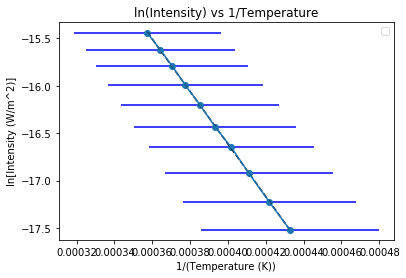

slope:  -27661.07751241576
thus h =  6.956706786357373e-34
std_err:  100.84202768455474
error in h:
2.5361572340350696e-36


In [60]:
# for future use:
def getPlancksConstant(slope):
    return (-slope * kb)/v

# Using scipy.stats.linregress for a check on the slope and uncertainty
x = dv.RecipTemperature
y = dv.lnIntensity
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.legend()
plt.title("ln(Intensity) vs 1/Temperature")
plt.xlabel("1/(Temperature (K))")
plt.ylabel("ln[Intensity (W/m^2)]")
plt.errorbar(x,y,xerr=dv.sigmaRecipT, ecolor="b")
plt.plot(x, y, 'o', label='data')
plt.plot(x, intercept + slope*x, 'k--', label='fit')
plt.show()
print("slope: ", slope)
print("thus h = ", getPlancksConstant(slope))
print("std_err: ", std_err)
print("error in h:")
print(np.sqrt(std_err**2 * (kb/v)**2))